In [133]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST Dataset

In [15]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [17]:
X,y = mnist['data'],mnist['target']
X.shape

(70000, 784)

In [18]:
y.shape

(70000,)

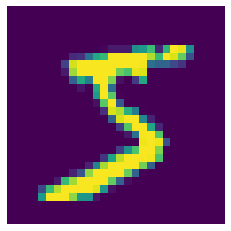

In [53]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image)
plt.axis("off")

# save_fig("some_digit_plot")
plt.show()

In [24]:
y[0]

'5'

In [28]:
type(y[0])

str

In [33]:
y = y.astype(np.uint8)

In [34]:
type(y[0])

numpy.uint8

In [35]:
y[0]

5

In [36]:
def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image,cmap = mpl.cm.binary,
              interpolation='nearest')
    plt.axis("off")

In [44]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


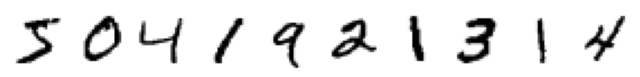

In [45]:
plt.figure(figsize=(9,9))
example_images = X[:10]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [42]:
X_train,y_train,X_test,y_test = X[:60000],y[:60000],X[60000:],y[60000:]

# Binary Classifier

In [48]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [50]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000,tol=1e-3,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [51]:
sgd_clf.predict([some_digit])

array([ True])

In [52]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Though the accuracy is higher, it doesn't give proper results. To get accurate result, we will use confusion matrix

To compute the confusion matrix, first need to have a set of predictions so that they can be compared to the actual targets. 

In [54]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [58]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives), while the remaining 3530 were correctly classified as 5s (true positives).

In [57]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

precision = TP/(TP+FP)
recall = TP/(TP+FN)

In [60]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [61]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s

The F1 score is the harmonic mean of precision and recall
F1 = TP/(TP+(FN+FP)/2)

In [62]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

# Multiclass Classifier

In [63]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [64]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [65]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [66]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [68]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

# Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you may want your classifier to output multiple classes for each instance.

In [70]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

5 is smaller than 7 and it is odd. So the prediction is accurate

In [72]:
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average="macro")

0.976410265560605

# Multioutput Classification

The last type of classification task we are going to discuss here is called multioutput–multiclass classification (or simply multioutput classification). It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

In [76]:
#adding noise by randint() function
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test+noise
y_train_mod = X_train
y_test_mod = X_test

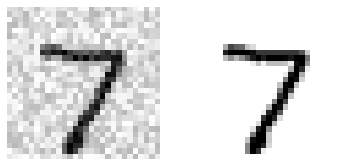

In [77]:
some_index = 0
plt.subplot(121);plot_digit(X_test_mod[some_index])
plt.subplot(122);plot_digit(y_test_mod[some_index])
plt.show()

Saving figure cleaned_digit_example_plot


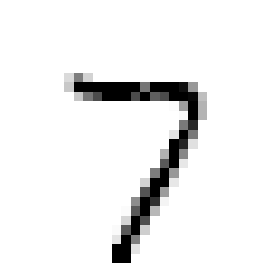

In [78]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

# Exercise

1. Try to build a classifier for the MNIST dataset that achieves over
97% accuracy on the test set. Hint: the KNeighborsClassifier
works quite well for this task; you just need to find good
hyperparameter values (try a grid search on the and hyperparameters).

In [79]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_train)

KNeighborsClassifier()

In [81]:
y_pred = knn_clf.predict(X_test)
f1_score(y_test,y_pred,average="weighted")

0.9687470572168784

In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights':['uniform','distance'],'n_neighbors':[3,4,5]}]
grid_search = GridSearchCV(knn_clf,param_grid,cv=3)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}])

In [84]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [85]:
grid_search.best_score_

0.9703500000000002

In [86]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test,y_pred)

0.9714

2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

# Augmentation

In [88]:
from scipy.ndimage.interpolation import shift

In [100]:
def shift_image(image, x, y):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [y, x], cval=0, mode="constant")
    return shifted_image.reshape([-1])

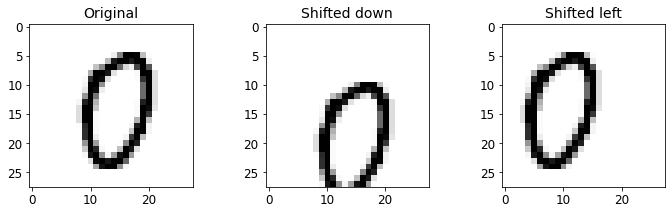

In [101]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [102]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for x,y in ((1,0),(-1,0),(0,1),(0,-1)):
    for image,label in zip(X_train,y_train):
        X_train_augmented.append(shift_image(image,x,y))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [103]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [104]:
knn_clf.fit(X_train_augmented,y_train_augmented)

KNeighborsClassifier()

In [105]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9754

Accuracy increased for augmentation

3. Tackle the Titanic dataset. A great place to start is on Kaggle.

In [113]:
import pandas as pd

train_data = pd.read_csv("datasets/titanic/train.csv")
test_data = pd.read_csv("datasets/titanic/test.csv")

In [115]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [116]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [118]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [119]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [120]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [121]:
s = (train_data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [123]:
numerical_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
numerical_cols

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numerical_transformer = SimpleImputer(strategy="median")

categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy="most_frequent")),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, object_cols)
    ])

In [129]:
y_train = train_data['Survived']

In [130]:
X_train = preprocessor.fit_transform(train_data)

In [131]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier()
rnd_scores = cross_val_score(rnd_clf,X_train,y_train,cv=5)
rnd_scores.mean()

1.0

In [132]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=5)
svm_scores.mean()

0.6386353650116126